# Descripción del proyecto

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.
Necesitamos predecir si un cliente dejará el banco pronto. 

El objetivo del proyecto será realizar un modelo de predicción con el valor F1 más alto posible. Se utilizarán distintos métodos para medir la métrica.

Para lograrlo, primero se inspeccionaran los datos, se complementarán y adecuarán los valores; en caso de ser necesario. Despues se procederá a escoger el mejor modelo para la predicción, sustentando su eficiencia con métodos ppara medir la calidad.

## Inicio

In [1]:
#Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score



## Cargar los datos

In [2]:
try:
    data = pd.read_csv("/datasets/Churn.csv")
except:
    data = pd.read_csv("Churn.csv")

## Preprocesamiento de datos

In [3]:
data.info()
print()
print(f"Número de filas del conjunto de datos: ",data.shape[0])
print(f"Número de columnas del conjunto de datos: ",data.shape[1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB

Número de filas del conjunto de datos:  10000
Número de columnas del conjunto de datos:  14


Se puede apreciar que faltan datos en la columna `Tenure`, es necesario su revisarla para encontrar el motivo y evaluar como se trabajará. 

Los nombres de las columnas tienen un formato no adecuado, se procederá a utilizar minúsculas y separar palabras con `_`

La columna `RowNumber`, será eliminada debido a que no es necesaria porque se repite con el índice.

In [4]:
# Impresión muestra de los datos
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [5]:
#Función para corregir columnas a formato adecuado
def replace_column(string):
    n= [] #variable para almacenar lista de la posición de las mayusculas
    count = 0 #variable para correr espacios al agregar el caracter "_"

    for s in range(len(string)): #se buscan las posiciones de las mayusculas en el string
        if (string[s].isupper()) & (s != 0):
            n.append(s)
        
    c_list= list(string) #se covierte el string en una lista

    for a in n: #se agrega el "_" al string
        c_list.insert(a + count, "_")
        count += 1 
    string = "".join(c_list)
    return string.lower() #se cambia todo a minusculas

In [6]:
#Se corrgien todas las columnas
c = data.columns 
new_columns = []
for column in c:
    new_columns.append(replace_column(column))
data.columns = new_columns
data.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Se puede apreciar que las columnas ya tienen un formato adecuado.

### Datos row_number

Se decide eliminar la columna, debido a que se repite con el número de índice. 

In [7]:
data = data.drop("row_number", axis=1)

In [8]:
data.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Se comprueba que la columna se retiró de manera exitosa

### Datos customer_id

In [9]:
data.query('customer_id.isna()')

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No se encuentran valores ausentes

In [10]:
len(data["customer_id"].unique())

10000

Hay 10,000 IDs unicos, lo que quiere decir que no se duplican los datos.

In [11]:
data.query('customer_id < 0')

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No se encuentran valores extraños menores a 0.

Esta columna no contiene alguna característica que ayude al modelo a determinar el objetivo, por consiguiente se eliminará para no ingresar datos innecesarios.

In [12]:
data = data.drop("customer_id", axis=1)

In [13]:
data.head()

,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


 Se comprueba la eliminación de la columna.

### Datos surname

In [14]:
data.query('surname.isna()')

,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No se encuentran valores ausentes

In [15]:
len(data["surname"].unique())

2932

Solo se encuentran 2,932 apellidos, puede haber muchos apellidos repetidos.

Esta columna no contiene alguna característica que ayude al modelo a determinar el objetivo, por consiguiente se eliminará para no ingresar datos innecesarios.

In [16]:
data = data.drop("surname", axis=1)

In [17]:
data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Se comprueba eliminación de la columna.

### Datos credit_score

In [18]:
data.query('credit_score.isna()')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No se encuentra valores ausentes

In [19]:
data["credit_score"].unique()

array([619, 608, 502, 699, 850, 645, 822, 376, 501, 684, 528, 497, 476,
       549, 635, 616, 653, 587, 726, 732, 636, 510, 669, 846, 577, 756,
       571, 574, 411, 591, 533, 553, 520, 722, 475, 490, 804, 582, 472,
       465, 556, 834, 660, 776, 829, 637, 550, 698, 585, 788, 655, 601,
       656, 725, 511, 614, 742, 687, 555, 603, 751, 581, 735, 661, 675,
       738, 813, 657, 604, 519, 664, 678, 757, 416, 665, 777, 543, 506,
       493, 652, 750, 729, 646, 647, 808, 524, 769, 730, 515, 773, 814,
       710, 413, 623, 670, 622, 785, 605, 479, 685, 538, 562, 721, 628,
       668, 828, 674, 625, 432, 770, 758, 795, 686, 789, 589, 461, 584,
       579, 663, 682, 793, 691, 485, 650, 754, 535, 716, 539, 706, 586,
       631, 717, 800, 683, 704, 615, 667, 484, 480, 578, 512, 606, 597,
       778, 514, 525, 715, 580, 807, 521, 759, 516, 711, 618, 643, 671,
       689, 620, 676, 572, 695, 592, 567, 694, 547, 594, 673, 610, 767,
       763, 712, 703, 662, 659, 523, 772, 545, 634, 739, 771, 68

No parece haber valores anormales.

In [20]:
data.query('credit_score < 0')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No se encuentran valores menores que 0

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            9091 non-null   float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


La columna tiene el tipo de valor int, adecuado para los valores que tiene.

### Datos geography

In [22]:
data.query('geography.isna()')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


La columna no contiene valores ausentes.

In [23]:
data["geography"].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

No se encuentran valores anomalos o mal escritos. Solo se cambiarán las mayusculas a minusculas.

In [24]:
#se convierte todo a minusculas de lacolumna geography
data["geography"] = data["geography"].str.lower()

In [25]:
data["geography"].unique()

array(['france', 'spain', 'germany'], dtype=object)

Se comprueba conversión

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            9091 non-null   float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


El tipo de datos en la columna es el adecuado.

### Datos gender

In [27]:
data.query('gender.isna()')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


In [28]:
data["gender"].unique()

array(['Female', 'Male'], dtype=object)

No se encuentran valores anomalos o mal escritos. Solo se cambiarán las mayusculas a minusculas.

In [29]:
#se convierte todo a minusculas de lacolumna geography
data["gender"] = data["gender"].str.lower()

In [30]:
data["gender"].unique()

array(['female', 'male'], dtype=object)

Se comprueba conversión

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            9091 non-null   float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


### Datos age

In [32]:
data.query('age.isna()')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


In [33]:
data["age"].unique()

array([42, 41, 39, 43, 44, 50, 29, 27, 31, 24, 34, 25, 35, 45, 58, 32, 38,
       46, 36, 33, 40, 51, 61, 49, 37, 19, 66, 56, 26, 21, 55, 75, 22, 30,
       28, 65, 48, 52, 57, 73, 47, 54, 72, 20, 67, 79, 62, 53, 80, 59, 68,
       23, 60, 70, 63, 64, 18, 82, 69, 74, 71, 76, 77, 88, 85, 84, 78, 81,
       92, 83])

No se encuentran valores atipicos

In [34]:
data.query('credit_score < 0')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No hay valores menores de 0

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            9091 non-null   float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


El tipo de datos de la columna es int, el adecuado para edades.

### Datos tenure

In [36]:
print("Porcentaje de datos faltantes en la colunmna tenure",
      round(len(data.query('tenure.isna()'))/len(data)*100, 2), "%")

Porcentaje de datos faltantes en la colunmna tenure 9.09 %


In [37]:
data.query('tenure.isna()')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,591,spain,female,39,NaN,0.00,3,1,0,140469.38,1
48,550,germany,male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,germany,male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,germany,male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,germany,male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,germany,male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,france,female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,france,male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,france,male,36,NaN,123841.49,2,1,0,96833.00,0


In [38]:
data.query('tenure == 0')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
29,411,france,male,29,0.0,59697.17,2,1,1,53483.21,0
35,475,france,female,45,0.0,134264.04,1,1,0,27822.99,1
57,725,germany,male,19,0.0,75888.20,1,0,0,45613.75,0
72,657,spain,female,37,0.0,163607.18,1,0,1,44203.55,0
127,625,germany,male,56,0.0,148507.24,1,1,0,46824.08,1
...,...,...,...,...,...,...,...,...,...,...,...
9793,772,germany,female,42,0.0,101979.16,1,1,0,90928.48,0
9799,653,france,male,46,0.0,119556.10,1,1,0,78250.13,1
9843,646,germany,male,24,0.0,92398.08,1,1,1,18897.29,0
9868,718,france,female,43,0.0,93143.39,1,1,0,167554.86,0


Se puede apreciar que hay varios valores ausentes en la columna `tenure`. A continuación, se analizará si existe algun patrón por el cual no fueron llenados.

In [39]:
na_tenure = data.query('tenure.isna()')

In [40]:
for columns in na_tenure.columns:
    if columns not in ("tenure") :
        print(f"Porcentaje de valores ausentes con respecto a la columna {columns}")
        print(na_tenure[columns].value_counts(normalize=True))
        print("_______________________")

Porcentaje de valores ausentes con respecto a la columna credit_score
850    0.025303
651    0.009901
630    0.009901
652    0.008801
706    0.008801
         ...   
500    0.001100
683    0.001100
503    0.001100
504    0.001100
359    0.001100
Name: credit_score, Length: 349, dtype: float64
_______________________
Porcentaje de valores ausentes con respecto a la columna geography
france     0.510451
spain      0.251925
germany    0.237624
Name: geography, dtype: float64
_______________________
Porcentaje de valores ausentes con respecto a la columna gender
male      0.531353
female    0.468647
Name: gender, dtype: float64
_______________________
Porcentaje de valores ausentes con respecto a la columna age
36    0.060506
38    0.058306
40    0.053905
31    0.049505
32    0.048405
37    0.047305
35    0.047305
33    0.042904
39    0.039604
34    0.038504
29    0.038504
43    0.035204
30    0.034103
41    0.030803
28    0.028603
44    0.026403
42    0.026403
45    0.024202
26    0.01980

No parece haber patrón con respecto a la columna `credit_score`.

El 51% de los valores ausentes son de nacionalidad francesa.

El 53% de los valores usentes son de género masculino.

No parece haber un patron con respecto a la columna `age`.

El 51% de los valores ausentes son clientes que han utilizado 1 producto bancario.

El 71% de los valores ausentes tiene una tarjeta de credito.

El 51% de los valores ausentes es un cliente activo.

El 79% de los valores ausente son clientes que se han ido.

Segun la agrupación de los valores ausentes con respecto a la columna `tenure`, la gran mayoria de los clientes que se han ido tiene valores ausentes en la columna.
No parece haber un patrón obvio para complementar el valor y los valores ausentes no pueden ser ceros porque si hay datos en los que se complementan con 0.

Debido a que no se puede determinar el valor, se procederá a eliminar las filas con valores ausentes.

In [41]:
data = data.query('tenure.isna() == False').reset_index(drop= True)

In [42]:
data.query('tenure.isna()')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


Se aprecia que ya no existen valores ausente en la columna

In [43]:
#Se cambian los valores a tipo int
data["tenure"] = data["tenure"].astype(int)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   int64  
 1   geography         9091 non-null   object 
 2   gender            9091 non-null   object 
 3   age               9091 non-null   int64  
 4   tenure            9091 non-null   int64  
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   int64  
 7   has_cr_card       9091 non-null   int64  
 8   is_active_member  9091 non-null   int64  
 9   estimated_salary  9091 non-null   float64
 10  exited            9091 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 781.4+ KB


Se comprueba la conversión de los datos de la columna a tipo int.

### Datos balance

In [45]:
data.query('balance.isna()')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No hay valores ausentes

In [46]:
data.query('balance < 0')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No hay valores negativos en la columna.

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   int64  
 1   geography         9091 non-null   object 
 2   gender            9091 non-null   object 
 3   age               9091 non-null   int64  
 4   tenure            9091 non-null   int64  
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   int64  
 7   has_cr_card       9091 non-null   int64  
 8   is_active_member  9091 non-null   int64  
 9   estimated_salary  9091 non-null   float64
 10  exited            9091 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 781.4+ KB


La columna balance tiene el tipo de datos correcto.

### Datos num_of_products

In [48]:
data.query('num_of_products.isna()')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No se encuentran valores ausentes


In [49]:
data["num_of_products"].unique()

array([1, 3, 2, 4])

No se encuentran valores atípicos

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   int64  
 1   geography         9091 non-null   object 
 2   gender            9091 non-null   object 
 3   age               9091 non-null   int64  
 4   tenure            9091 non-null   int64  
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   int64  
 7   has_cr_card       9091 non-null   int64  
 8   is_active_member  9091 non-null   int64  
 9   estimated_salary  9091 non-null   float64
 10  exited            9091 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 781.4+ KB


El tipo de datos de la columna es correcto.

### Datos has_cr_card

In [51]:
data.query('has_cr_card.isna()')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No se encuentran valores ausentes.

In [52]:
data["has_cr_card"].unique()

array([1, 0])

No se encuentran valores atípicos

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   int64  
 1   geography         9091 non-null   object 
 2   gender            9091 non-null   object 
 3   age               9091 non-null   int64  
 4   tenure            9091 non-null   int64  
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   int64  
 7   has_cr_card       9091 non-null   int64  
 8   is_active_member  9091 non-null   int64  
 9   estimated_salary  9091 non-null   float64
 10  exited            9091 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 781.4+ KB


El tipo de datos en la columna es el adecuado.

### Datos is_active_member

In [54]:
data.query('is_active_member.isna()')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No se encuentran valore ausentes

In [55]:
data["is_active_member"].unique()

array([1, 0])

No se encuentran valores atípicos.

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   int64  
 1   geography         9091 non-null   object 
 2   gender            9091 non-null   object 
 3   age               9091 non-null   int64  
 4   tenure            9091 non-null   int64  
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   int64  
 7   has_cr_card       9091 non-null   int64  
 8   is_active_member  9091 non-null   int64  
 9   estimated_salary  9091 non-null   float64
 10  exited            9091 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 781.4+ KB


El tipo de datos es el adecuado para la columna.

### Datos estimated_salary

In [57]:
data.query('estimated_salary.isna()')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No se encuentran valores ausentes.

In [58]:
data.query('estimated_salary < 0')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No se encuentran valores menores a 0

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   int64  
 1   geography         9091 non-null   object 
 2   gender            9091 non-null   object 
 3   age               9091 non-null   int64  
 4   tenure            9091 non-null   int64  
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   int64  
 7   has_cr_card       9091 non-null   int64  
 8   is_active_member  9091 non-null   int64  
 9   estimated_salary  9091 non-null   float64
 10  exited            9091 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 781.4+ KB


El tipo de datos de la columna es el adecuado

### Datos exited

In [60]:
data.query('exited.isna()')

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No se encuentran valores ausentes

In [61]:
data["exited"].unique()

array([1, 0])

No se encuentra valores atipicos

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   int64  
 1   geography         9091 non-null   object 
 2   gender            9091 non-null   object 
 3   age               9091 non-null   int64  
 4   tenure            9091 non-null   int64  
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   int64  
 7   has_cr_card       9091 non-null   int64  
 8   is_active_member  9091 non-null   int64  
 9   estimated_salary  9091 non-null   float64
 10  exited            9091 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 781.4+ KB


El tipo de datos es el adecuado para la columna.

## Preparación de datos apra el modelo

### Creación de variable dummies y codificación de etiquetas

Debido a que se tienen dos columnas con variables categóricas `geography` y `gender`. Se convertiran en variable numéricas aplicando One Hot Encoding y codificación de etiquitas, porque se trabajarán modelos de regresión logísticas y arbol.

In [63]:
#creación de variables dummies
data_ohe = pd.get_dummies(data, drop_first=True)

In [64]:
#creación de codificador de etiquetas
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)

### Creación de variables features y target con OHE

In [65]:
#Se guarda en la variable todas las columnas execpto exited
features_ohe = data_ohe.drop("exited", axis=1)

In [66]:
#Verificar la variable
features_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0


In [67]:
#Solo se guarda en la variable la columna 
target_ohe = data["exited"]

In [68]:
#Se verifica la variable
target_ohe.head()

0    1
1    0
2    1
3    0
4    0
Name: exited, dtype: int64

### Creación de variables features y target con Codificación de etiquetas

In [69]:
features_cod = data_ordinal.drop("exited", axis=1)

In [70]:
#Verificar la variable
features_cod.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
0,226.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,4609.0
1,215.0,2.0,0.0,23.0,1.0,679.0,0.0,0.0,1.0,5119.0
2,109.0,0.0,0.0,24.0,8.0,5277.0,2.0,1.0,0.0,5182.0
3,306.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4274.0
4,457.0,2.0,0.0,25.0,2.0,3374.0,0.0,1.0,1.0,3559.0


In [71]:
target_cod = data_ordinal["exited"]

In [72]:
target_cod.head()

0    1.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: exited, dtype: float64

### Segmentación de los conjuntos de entrenamiento,  validación y test OHE

In [73]:
# Segmenos para OHE
(features_train_ohe, features_valid_ohe, 
 target_train_ohe, target_valid_ohe) = train_test_split(features_ohe, target_ohe, 
                                              test_size=0.40, random_state= 931106)
(features_valid_ohe, features_test_ohe,
target_valid_ohe, target_test_ohe) = train_test_split(features_valid_ohe, target_valid_ohe, 
                                              test_size=0.50, random_state= 931106)

In [74]:
print(f"Número de filas del conjunto de datos features_train: "
      ,features_train_ohe.shape[0])
print(f"Número de filas del conjunto de datos features_valid: "
      ,features_valid_ohe.shape[0])
print(f"Número de filas del conjunto de datos features_test: "
      ,features_test_ohe.shape[0])

Número de filas del conjunto de datos features_train:  5454
Número de filas del conjunto de datos features_valid:  1818
Número de filas del conjunto de datos features_test:  1819


### Segmentación de los conjuntos de entrenamiento,  validación y test Codificación de etiquetas

In [75]:
# Segmenos para codificación de etiquetas
(features_train_cod, features_valid_cod, 
 target_train_cod, target_valid_cod) = train_test_split(features_cod, target_cod, 
                                              test_size=0.40, random_state= 931106)
(features_valid_cod, features_test_cod,
target_valid_cod, target_test_cod) = train_test_split(features_valid_cod, target_valid_cod, 
                                              test_size=0.50, random_state= 931106)

In [76]:
print(f"Número de filas del conjunto de datos features_train: "
      ,features_train_cod.shape[0])
print(f"Número de filas del conjunto de datos features_valid: "
      ,features_valid_cod.shape[0])
print(f"Número de filas del conjunto de datos features_test: "
      ,features_test_cod.shape[0])

Número de filas del conjunto de datos features_train:  5454
Número de filas del conjunto de datos features_valid:  1818
Número de filas del conjunto de datos features_test:  1819


### Escalado de características

Estos datos contienen valores númericos con magnitudes grande entre las columnas numéricas, como: `credit_score`, `age`, `balance`, `tenure`, y `stimated_salary`. Lo cual, el algoritmo puede encontrar que alguna sea más importante que otra. Por consiguiente, se realizará un escalado de carácterísticas.

In [77]:
#Se establecen las columnas numericas que sera escaladas para OHE
numeric = ['credit_score', 'age', 'balance', 'tenure', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])


StandardScaler()

In [78]:
#Escalado para OHE
features_train_ohe[numeric]= scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

/tmp/ipykernel_44/123155250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_ohe[numeric]= scaler.transform(features_train_ohe[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [79]:
#Se establecen las columnas numericas que sera escaladas para Codificacion de etiquetas
numeric = ['credit_score', 'age', 'balance', 'tenure', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train_cod[numeric])

StandardScaler()

In [80]:
#Escalado para cod
features_train_cod[numeric]= scaler.transform(features_train_cod[numeric])
features_valid_cod[numeric] = scaler.transform(features_valid_cod[numeric])
features_test_cod[numeric] = scaler.transform(features_test_cod[numeric])

/tmp/ipykernel_44/1693459608.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_cod[numeric]= scaler.transform(features_train_cod[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

## Creacion del modelo

### Entrenando los modelos

Se crearán dos modelos, uno de regresión logística y otro de arbol de decisión.

In [81]:
model = LogisticRegression(random_state=931106, solver='liblinear')  # inicializa el constructor de regresión logística con los parámetros random_state=54321 y solver='liblinear'
model.fit(features_train_ohe, target_train_ohe) # entrena el modelo en el conjunto de entrenamiento
score_train = model.score(features_train_ohe, target_train_ohe) # calcula la puntuación de accuracy en el conjunto de entrenamiento
score_valid = model.score(features_valid_ohe, target_valid_ohe) # calcula la puntuación de accuracy en el conjunto de validación
score_test = model.score(features_test_ohe, target_test_ohe) # calcula la puntuación de accuracy en el conjunto de validación

print("Exactitud del modelo de regresión logística en el conjunto de entrenamiento:", score_train)
print("Exactitud del modelo de regresión logística en el conjunto de validación:", score_valid)
print("Exactitud del modelo de regresión logística en el conjunto de test:", score_test)


Exactitud del modelo de regresión logística en el conjunto de entrenamiento: 0.8160982764943161
Exactitud del modelo de regresión logística en el conjunto de validación: 0.8058305830583058
Exactitud del modelo de regresión logística en el conjunto de test: 0.7976910390324354


El modelo tiene buenos resultados, no presenta overfiting.

Se utilizara gridsearch para ajustar el mejor hiperaparametro

In [82]:
model = DecisionTreeClassifier(random_state=931106)
params = [{'max_depth': list(range(1, 20))}]
clf = GridSearchCV(model, params, cv = 20, scoring='f1')
clf.fit(features_train_cod, target_train_cod)
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 5}
0.5560837758010084


In [83]:
model = DecisionTreeClassifier(random_state=931106, max_depth= 5) 
model.fit(features_train_cod, target_train_cod) # entrena el modelo 
score = model.score(features_valid_cod, target_valid_cod) # calcula la exactitud
score_test = model.score(features_test_cod, target_test_cod) # calcula la exactitud
score_train = model.score(features_train_cod, target_train_cod) # calcula la exactitud

print("Exactitud del modelo en el conjunto de entranmiento:", score_train) 
print("Exactitud del modelo en el conjunto de validación:", score) 
print("Exactitud del modelo en el conjunto de prueba:", score_test) 


Exactitud del modelo en el conjunto de entranmiento: 0.861019435276861
Exactitud del modelo en el conjunto de validación: 0.8492849284928493
Exactitud del modelo en el conjunto de prueba: 0.8444200109950523


El modelo parece funcionar muy bien y no presenta overfiting.

### Prueba de consistencia

Tenemos muy buenos resultados en ambos modelos, arriba del 80% de precisión. Para confirmar los resultados, se realizarán pruebas de consistencia. Se verificará con que consistencia hay hay `1`s y `0`s en la columna target. 

In [84]:
class_frecuency = data["exited"].value_counts(normalize=True)
class_frecuency

0    0.796062
1    0.203938
Name: exited, dtype: float64

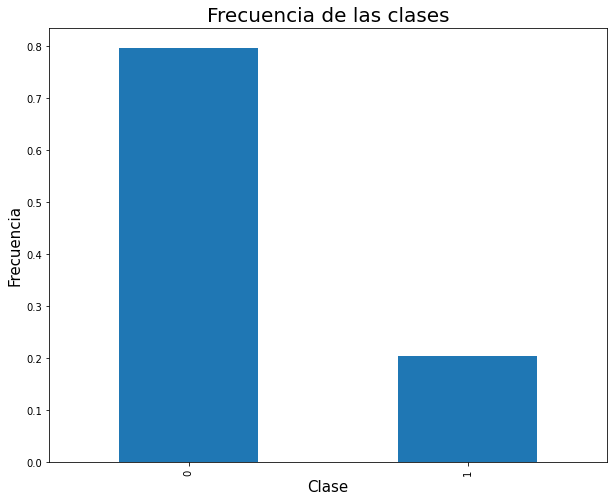

In [85]:
class_frecuency.plot(kind="bar", figsize=(10,8))
plt.title("Frecuencia de las clases",fontsize=20)
plt.xlabel('Clase', fontsize=15)
plt.ylabel('Frecuencia', fontsize=15)
plt.show()

Parece ser que solo el 20% de los clientes se ha ido, es una diferencia grande. Ahora probemos su comportamiento con las predicciones de los modelos

In [86]:
#Modelo regresión logística
model = LogisticRegression(random_state=931106, solver='liblinear')   
model.fit(features_train_ohe, target_train_ohe)
predicted_valid = pd.Series(model.predict(features_valid_ohe))

class_frequency = predicted_valid.value_counts(normalize=True)
print(class_frequency)


0    0.921892
1    0.078108
dtype: float64


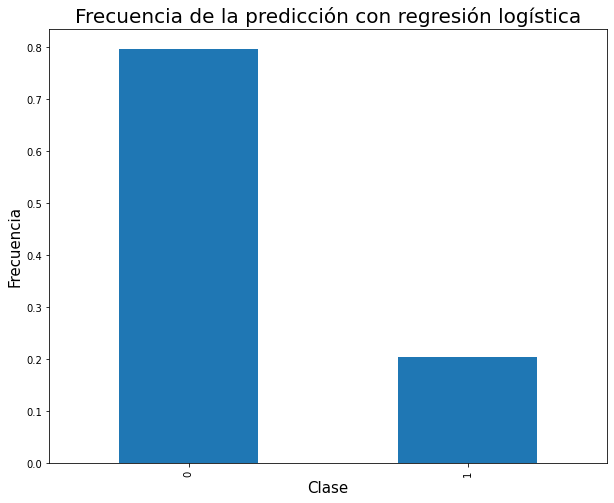

In [87]:
class_frecuency.plot(kind="bar", figsize=(10,8))
plt.title("Frecuencia de la predicción con regresión logística",fontsize=20)
plt.xlabel('Clase', fontsize=15)
plt.ylabel('Frecuencia', fontsize=15)
plt.show()

Se puede apreciar en el gráfico que sigue existiendo mucha diferencia entre las predicciones `0`s que `1`s.

In [88]:
#Modelo arbol de decision
model = DecisionTreeClassifier(random_state=931106, max_depth= 5) 
model.fit(features_train_cod, target_train_cod)
predicted_valid = pd.Series(model.predict(features_valid_cod))

class_frequency = predicted_valid.value_counts(normalize=True)
print(class_frequency)

0.0    0.886139
1.0    0.113861
dtype: float64


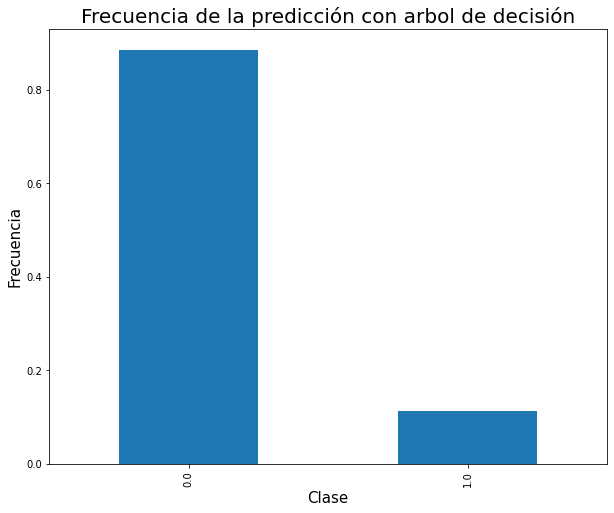

In [89]:
class_frequency.plot(kind="bar", figsize=(10,8))
plt.title("Frecuencia de la predicción con arbol de decisión",fontsize=20)
plt.xlabel('Clase', fontsize=15)
plt.ylabel('Frecuencia', fontsize=15)
plt.show()

Ocurre lo mismo con las predicciones del arbol de decisión hay más `0`s que `1`s. Esto puede deber al desbalance que hay en los datos.

In [90]:
#Columna de 0s
target_pred_constant = pd.Series(0, index=target_ohe.index)

print(accuracy_score(target_cod, target_pred_constant))

0.7960620393796062


Teniendo un columna con solo 0, nos da el 79% de precisión comparandola con la columna objetivo. Esto quiere decir que los modelos presentados no estan trabajando como deberían por el desequelibrio de las clases que existe. 

A continuación se calculará el valor F1, para conocer las medidas de combinadas de precisión y recall.

In [91]:
#F1 regresión logistica
model = LogisticRegression(random_state=931106, solver='liblinear')   
model.fit(features_train_ohe, target_train_ohe)
predicted_valid = pd.Series(model.predict(features_valid_ohe))

print("Valor F1 para el conjunto de validación:", f1_score(target_valid_ohe, predicted_valid))
f1_lr_na_val = f1_score(target_valid_ohe, predicted_valid)

predicted_valid = pd.Series(model.predict(features_test_ohe))
print("Valor F1 para el conjunto de test:", f1_score(target_test_ohe, predicted_valid))
f1_lr_na_tes = f1_score(target_test_ohe, predicted_valid)

Valor F1 para el conjunto de validación: 0.300990099009901
Valor F1 para el conjunto de test: 0.2950191570881226


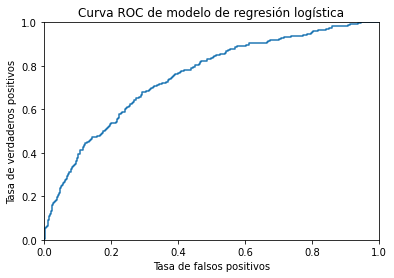

Valor AUC-ROC: 0.74958393683792


In [92]:
probabilities_valid = model.predict_proba(features_valid_ohe)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid_ohe, probabilities_one_valid)

fpr, tpr, thresholds = roc_curve(target_valid_ohe, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC de modelo de regresión logística')
plt.show() 
print("Valor AUC-ROC:", auc_roc)

In [93]:
#F1 arbol de decisión
model = DecisionTreeClassifier(random_state=931106, max_depth= 5) 
model.fit(features_train_cod, target_train_cod)
predicted_valid = pd.Series(model.predict(features_valid_cod))

print("Valor F1 para el conjunto de validación:", f1_score(target_valid_cod, predicted_valid))
f1_ts_na_val = f1_score(target_valid_cod, predicted_valid)

predicted_valid = pd.Series(model.predict(features_test_cod))
print("Valor F1 para el conjunto de test:", f1_score(target_test_cod, predicted_valid))
f1_ts_na_tes = f1_score(target_test_cod, predicted_valid)

Valor F1 para el conjunto de validación: 0.519298245614035
Valor F1 para el conjunto de test: 0.535303776683087


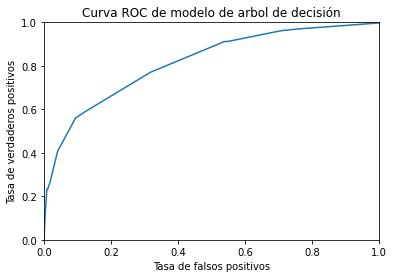

Valor AUC-ROC: 0.8165185122073594


In [94]:
probabilities_valid = model.predict_proba(features_valid_cod)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid_cod, probabilities_one_valid)

fpr, tpr, thresholds = roc_curve(target_valid_cod, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC de modelo de arbol de decisión')
plt.show() 
print("Valor AUC-ROC:", auc_roc)

Se puede apreciar que en ambos casos el valor F1, aunque se ve más afectado en la regresión logística. A continuación, se realizarán las correcciones necesarias al modelo para acercar lo más posible el valor F1 a 1.

## Correción de modelo por ajuste de peso de clase

In [95]:
#Regresión logistica
model = LogisticRegression(random_state=931106, solver='liblinear', class_weight= "balanced")  
model.fit(features_train_ohe, target_train_ohe)
predicted_valid = pd.Series(model.predict(features_valid_ohe))

print("Valor F1 para el conjunto de validación:", f1_score(target_valid_ohe, predicted_valid))
f1_lr_weight_val = f1_score(target_valid_ohe, predicted_valid) 

predicted_valid = pd.Series(model.predict(features_test_ohe))
print("Valor F1 para el conjunto de test:", f1_score(target_test_ohe, predicted_valid))
f1_lr_weight_tes = f1_score(target_test_ohe, predicted_valid)

Valor F1 para el conjunto de validación: 0.47591522157996147
Valor F1 para el conjunto de test: 0.5127719962157048


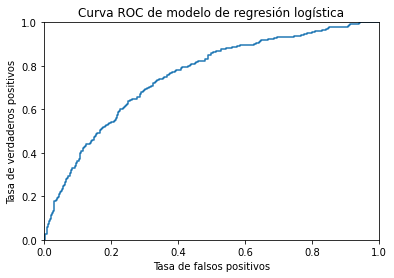

Valor AUC-ROC: 0.7544328003559494


In [96]:
probabilities_valid = model.predict_proba(features_valid_ohe)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid_ohe, probabilities_one_valid)

fpr, tpr, thresholds = roc_curve(target_valid_ohe, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC de modelo de regresión logística')
plt.show() 
print("Valor AUC-ROC:", auc_roc)

In [97]:
model = DecisionTreeClassifier(random_state=931106, class_weight= "balanced")
params = [{'max_depth': list(range(1, 20))}]
clf = GridSearchCV(model, params, cv = 20, scoring='f1')
clf.fit(features_train_cod, target_train_cod)
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 5}
0.5791594301416885


In [98]:
#Arbol de clasificación
model = DecisionTreeClassifier(random_state=931106, max_depth= 5, class_weight= "balanced") 
model.fit(features_train_cod, target_train_cod)
predicted_valid = pd.Series(model.predict(features_valid_cod))

print("Valor F1 para el conjunto de validación:", f1_score(target_valid_cod, predicted_valid))
f1_ts_weight_val = f1_score(target_valid_cod, predicted_valid) 

predicted_valid = pd.Series(model.predict(features_test_cod))
print("Valor F1 para el conjunto de test:", f1_score(target_test_cod, predicted_valid))
f1_ts_weight_tes = f1_score(target_test_cod, predicted_valid) 


Valor F1 para el conjunto de validación: 0.5790754257907543
Valor F1 para el conjunto de test: 0.5696821515892421


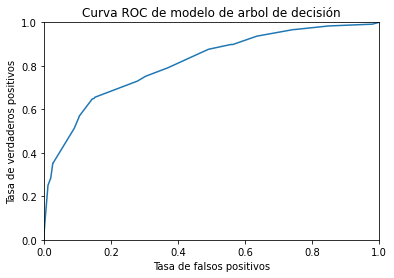

Valor AUC-ROC: 0.814087453731315


In [99]:
probabilities_valid = model.predict_proba(features_valid_cod)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid_cod, probabilities_one_valid)

fpr, tpr, thresholds = roc_curve(target_valid_cod, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC de modelo de arbol de decisión')
plt.show() 
print("Valor AUC-ROC:", auc_roc)

En ambor modelos hubo una gran mejora en los modelos, se puede observar un incremento sustancial en el valor de F1 para los conjuntos de validación y test. 

Se puede apreciar que para el modelo de regresión logistica fue el que más impacto tuvo la correción.



## Corrección de modelo con sobremuestreo

Para realizar la correción de sobre muestreo, se alterarán los conjuntos de entrenamiento. Para lograr el objetivo, se realizará una función que cree los nuevos conjuntos, dependienod del modelo que usemos. Posteriormente, se entrenaran los modelos.

A continuación se sacará la proporción entre el los resultados postivos y negativos del conjunto de entrenamiento.

In [100]:
rate = round(len(features_ohe[target_ohe == 0])/len(features_ohe[target_ohe == 1]))
print("La proporción entre los resultados positivos y negativos es:", rate)

La proporción entre los resultados positivos y negativos es: 4


In [101]:
#Función de sobremuestreo

def upsample(features, target, repeat, mod):
   
    if mod == 0: #mod = 0 es regresión logistica
        features_zeros = features_ohe[target_ohe == 0] # Se dividen el conjunto de datos en... 
        features_ones = features_ohe[target_ohe == 1] # ...observaciones negativas y positivas
        target_zeros = target_ohe[target_ohe == 0]
        target_ones = target_ohe[target_ohe == 1]
    else:
        features_zeros = features_cod[target_cod == 0] # Se dividen el conjunto de datos en... 
        features_ones = features_cod[target_cod == 1] # ...observaciones negativas y positivas
        target_zeros = target_cod[target_cod == 0]
        target_ones = target_cod[target_cod == 1]
        
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) #Se duplican las..
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat) #... observaciones positivas

    features_upsampled, target_upsampled = shuffle(  # Se barajean los datos
        features_upsampled, target_upsampled, random_state=931106
    )

    return features_upsampled, target_upsampled

In [102]:
#Creación de la variables de entrenamiento de sobremuetreo para regresión logistica
features_upsampled_ohe, target_upsampled_ohe = upsample(
    features_train_ohe, target_train_ohe, rate, 0
)
features_upsampled_ohe[numeric] = scaler.transform(features_upsampled_ohe[numeric])


In [103]:
#Creación de la variables de entrenamiento de sobremuetreo para arbol de decisión
features_upsampled_cod, target_upsampled_cod = upsample(
    features_train_cod, target_train_cod, rate, 1
)
features_upsampled_cod[numeric] = scaler.transform(features_upsampled_cod[numeric])


In [104]:
#Se corrobora que el nuevo conjuto creado por la función...
# ...esten balanceadas las clases
target_upsampled_cod.value_counts()


1.0    7416
0.0    7237
Name: exited, dtype: int64

In [105]:
#Regresión logistica
model = LogisticRegression(random_state=931106, solver='liblinear')  
model.fit(features_upsampled_ohe, target_upsampled_ohe)
predicted_valid = model.predict(features_valid_ohe)

print("Valor F1 para el conjunto de validación:", f1_score(target_valid_ohe, predicted_valid))
f1_lr_up_val = f1_score(target_valid_ohe, predicted_valid) 

predicted_valid = pd.Series(model.predict(features_test_ohe))
print("Valor F1 para el conjunto de test:", f1_score(target_test_ohe, predicted_valid))
f1_lr_up_tes = f1_score(target_test_ohe, predicted_valid) 


Valor F1 para el conjunto de validación: 0.2738589211618257
Valor F1 para el conjunto de test: 0.2784313725490196


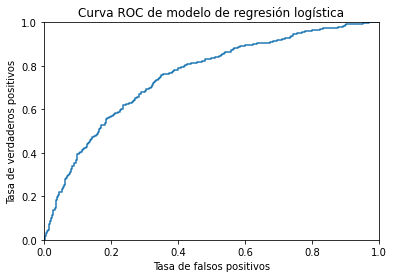

Valor AUC-ROC: 0.754444160442286


In [106]:
probabilities_valid = model.predict_proba(features_valid_ohe)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid_ohe, probabilities_one_valid)

fpr, tpr, thresholds = roc_curve(target_valid_ohe, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC de modelo de regresión logística')
plt.show() 
print("Valor AUC-ROC:", auc_roc)

In [107]:
model = DecisionTreeClassifier(random_state=931106)
params = [{'max_depth': list(range(1, 20))}]
clf = GridSearchCV(model, params, cv = 10, scoring='f1')
clf.fit(features_upsampled_cod, target_upsampled_cod)
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 19}
0.9331411910916294


In [108]:
#Arbol de clasificación
model = DecisionTreeClassifier(random_state=931106, max_depth= 19) 
model.fit(features_upsampled_cod, target_upsampled_cod)
predicted_valid = model.predict(features_valid_cod)

print("Valor F1 para el conjunto de validación:", f1_score(target_valid_cod, predicted_valid))
f1_ts_up_val = f1_score(target_valid_cod, predicted_valid) 

predicted_valid = pd.Series(model.predict(features_test_cod))
print("Valor F1 para el conjunto de test:", f1_score(target_test_cod, predicted_valid))
f1_ts_up_tes = f1_score(target_test_cod, predicted_valid) 


Valor F1 para el conjunto de validación: 0.9797023004059541
Valor F1 para el conjunto de test: 0.9871794871794872


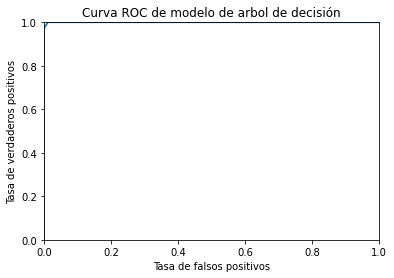

Valor AUC-ROC: 0.999843798812871


In [109]:
probabilities_valid = model.predict_proba(features_valid_cod)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid_cod, probabilities_one_valid)

fpr, tpr, thresholds = roc_curve(target_valid_cod, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC de modelo de arbol de decisión')
plt.show() 
print("Valor AUC-ROC:", auc_roc)

### Correción de modelo con submuestreo

Para realizar la correción de submuestreo, se alterarán los conjuntos de entrenamiento. Para lograr el objetivo, se realizará una función que cree los nuevos conjuntos, dependienod del modelo que usemos. Posteriormente, se entrenaran los modelos.

In [110]:
def downsample(features, target, fraction, mod):
    
    if mod == 0: #mod = 0 es regresión logistica
        features_zeros = features_ohe[target_ohe == 0] # Se dividen el conjunto de datos en... 
        features_ones = features_ohe[target_ohe == 1] # ...observaciones negativas y positivas
        target_zeros = target_ohe[target_ohe == 0]
        target_ones = target_ohe[target_ohe == 1]
    else:
        features_zeros = features_cod[target_cod == 0] # Se dividen el conjunto de datos en... 
        features_ones = features_cod[target_cod == 1] # ...observaciones negativas y positivas
        target_zeros = target_cod[target_cod == 0]
        target_ones = target_cod[target_cod == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=931106)] #Se suelta una parte al azar...
        + [features_ones]   # ... de las observaciones negativas
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=931106)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(    #Se barajean los datos
        features_downsampled, target_downsampled, random_state=931106
    )

    return features_downsampled, target_downsampled

In [111]:
#Creación de la variables de entrenamiento de sobremuetreo para regresión logistica
features_downsampled_ohe, target_downsampled_ohe = downsample(
    features_train_ohe, target_train_ohe, 1/rate, 0
)
features_downsampled_ohe[numeric] = scaler.transform(features_downsampled_ohe[numeric])


In [112]:
#Creación de la variables de entrenamiento de sobremuetreo para arbol de decisión
features_downsampled_cod, target_downsampled_cod = downsample(
    features_train_cod, target_train_cod, 1/rate, 1
)
features_downsampled_cod[numeric] = scaler.transform(features_downsampled_cod[numeric])


In [113]:
#Se corrobora que el nuevo conjuto creado por la función...
# ...esten balanceadas las clases
target_downsampled_cod.value_counts()


1.0    1854
0.0    1809
Name: exited, dtype: int64

In [114]:
#Regresión logistica
model = LogisticRegression(random_state=931106, solver='liblinear')  
model.fit(features_downsampled_ohe, target_downsampled_ohe)
predicted_valid = model.predict(features_valid_ohe)

print("Valor F1 para el conjunto de validación:", f1_score(target_valid_ohe, predicted_valid))
f1_lr_down_val = f1_score(target_valid_ohe, predicted_valid) 

predicted_valid = model.predict(features_test_ohe)
print("Valor F1 para el conjunto de test:", f1_score(target_test_ohe, predicted_valid))
f1_lr_down_tes = f1_score(target_test_ohe, predicted_valid) 


Valor F1 para el conjunto de validación: 0.27628865979381445
Valor F1 para el conjunto de test: 0.28460038986354774


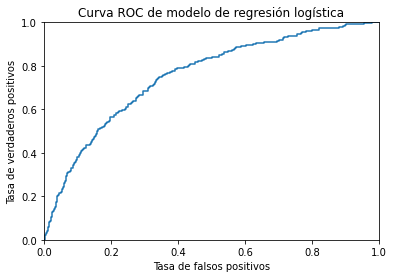

Valor AUC-ROC: 0.7535580737080269


In [115]:
probabilities_valid = model.predict_proba(features_valid_ohe)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid_ohe, probabilities_one_valid)

fpr, tpr, thresholds = roc_curve(target_valid_ohe, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC de modelo de regresión logística')
plt.show() 
print("Valor AUC-ROC:", auc_roc)

In [116]:
model = DecisionTreeClassifier(random_state=931106)
params = [{'max_depth': list(range(1, 20))}]
clf = GridSearchCV(model, params, cv = 20, scoring='f1')
clf.fit(features_downsampled_cod, target_downsampled_cod)
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 7}
0.7530788732756302


In [117]:
#Arbol de decision
model = DecisionTreeClassifier(random_state=931106, max_depth= 7) 
model.fit(features_downsampled_cod, target_downsampled_cod)
predicted_valid = model.predict(features_valid_cod)

print("Valor F1 para el conjunto de validación:", f1_score(target_valid_cod, predicted_valid))
f1_ts_down_val = f1_score(target_valid_cod, predicted_valid) 

predicted_valid = model.predict(features_test_cod)
print("Valor F1 para el conjunto de test:", f1_score(target_test_cod, predicted_valid))
f1_ts_down_tes = f1_score(target_test_cod, predicted_valid) 


Valor F1 para el conjunto de validación: 0.5475285171102661
Valor F1 para el conjunto de test: 0.603415559772296


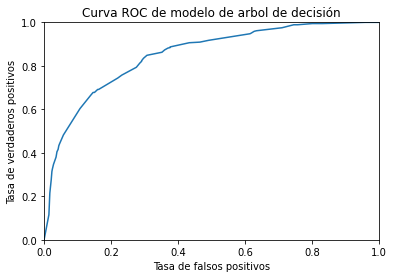

Valor AUC-ROC: 0.8488701447464334


In [118]:
probabilities_valid = model.predict_proba(features_valid_cod)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid_cod, probabilities_one_valid)

fpr, tpr, thresholds = roc_curve(target_valid_cod, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC de modelo de arbol de decisión')
plt.show() 
print("Valor AUC-ROC:", auc_roc)

In [119]:
#Tabla comparativa del valor f1 con el modelo de regresión logistica conjunto de validación
mode = ["modelo", "conjunto de datos","sin ajuste", 
        "ajuste de peso de clases", "sobremuestreo", 
        "submuestreo"]

value = [["regresión lineal", "validación", f1_lr_na_val, 
          f1_lr_weight_val, f1_lr_up_val, f1_lr_down_val],
         ["regresión lineal", "test", f1_lr_na_tes,
          f1_lr_weight_tes, f1_lr_up_tes, f1_lr_down_tes],
        ["arbol de decisión", "validación", f1_ts_na_val, 
         f1_ts_weight_val, f1_ts_up_val, f1_ts_down_val],
         ["arbol de decisión", "test", f1_ts_na_tes, 
          f1_ts_weight_tes, f1_ts_up_tes, f1_ts_down_tes]
        ]
tabla = pd.DataFrame(value, columns= mode )

## Conclusión

Se trabajó con dos modelos y tres técnicas de correción del valor F1, debido a que se encontró un desbalance en los datos objetivos de una proporción 90% de respuestas negativas y 10 respuestas positivas. Obteniendo los siguientes resultados:


In [120]:
tabla

,modelo,conjunto de datos,sin ajuste,ajuste de peso de clases,sobremuestreo,submuestreo
0,regresión lineal,validación,0.300990,0.475915,0.273859,0.276289
1,regresión lineal,test,0.295019,0.512772,0.278431,0.284600
2,arbol de decisión,validación,0.519298,0.579075,0.979702,0.547529
3,arbol de decisión,test,0.535304,0.569682,0.987179,0.603416


Conclusiones para el modelo de regresión lineal:

1. El modelo sin ajuste inció en 30%, a pesar que todas técnicas de correción mejoraba el valor de F1, no logró alcanzar el objetivo. Incluso se puede apreciar que las técnicas de sobremuestreo y submuestro no mejoraron el valor de F1

2. Se les realizó la prueba AUC-ROC para determinar el aprendizaje del modelo y no estuviera trabajando de modo aleatorio, lo cual paso satifactoriamente porque no todos los valores fueron distintos a 0.5.

Conclusiones para el modelo de arbol de decisión:

1. El modelo sin ajuste inició en 53%, este modelo es el que tuvo mayores cambios en las técnicas de corrección, debido a que alcanzó un 98% de valor de F1 con la técnica de sobremuestreo, pero la técnica de submuestreo no benefició en mucho y bajo el valor hasta 42%.

2. Se les realizó la prueba AUC-ROC para determinar el aprendizaje del modelo y no estuviera trabajando de modo aleatorio, lo cual paso satifactoriamente porque no todos los valores fueron distintos a 0.5.

Como observación general, la regresión lineal muestra mejora solo con la técnica de balanceo del hiperparametro, sin embargo las muestras de sobremuestreo y submuestreo tuvieron un impacto negativo, debido a que empeoraron el valor F1. 
Por otro lado, el modelo de arbol de decisión tuvo muy buenos resultados en todas las técnicas implementadas. La que menos impacto tuvo fue el submustreo, esto pude deberse a que tenemos pocos datos y al reducir aun más los datos objetivo, el modelo no tiene suficiente información.